In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from scipy.io import loadmat
from scipy import signal
import gc  # Garbage collection

def apply_spatial_filter(data):
    """Apply spatial filtering (CAR) efficiently"""
    channel_mean = np.mean(data, axis=1, keepdims=True)
    return data - channel_mean

def apply_memory_normalization(data):
    """Apply optimal normalization for memory data"""
    # Per-trial robust normalization to preserve memory-related amplitude differences
    n_trials, n_channels, n_times = data.shape
    normalized_data = np.zeros_like(data)

    for i in range(n_trials):
        if i % 1000 == 0:
            print(f"  Normalizing trial {i}/{n_trials}")

        trial_data = data[i]  # Shape: (channels, time)

        # Robust normalization per trial (less sensitive to outliers than z-score)
        trial_median = np.median(trial_data)
        trial_mad = np.median(np.abs(trial_data - trial_median))  # Median Absolute Deviation

        # Normalize: (data - median) / (1.4826 * MAD)
        # 1.4826 makes MAD equivalent to std for normal distribution
        if trial_mad > 0:
            normalized_data[i] = (trial_data - trial_median) / (1.4826 * trial_mad)
        else:
            normalized_data[i] = trial_data - trial_median

    return normalized_data

def apply_bandpass_filter_safe(data, fs=100, low_freq=0.5, high_freq=45.0, order=4):
    """Apply bandpass filter with memory management"""
    # Create filter coefficients
    nyquist = fs / 2
    low_norm = low_freq / nyquist
    high_norm = high_freq / nyquist
    b, a = signal.butter(order, [low_norm, high_norm], btype='band')

    # Process trial by trial to save memory
    n_trials, n_channels, n_times = data.shape
    data_filtered = np.zeros_like(data, dtype=np.float32)  # Use float32 to save memory

    for i in range(n_trials):
        if i % 1000 == 0:
            print(f"  Filtering trial {i}/{n_trials}")
        data_filtered[i] = signal.filtfilt(b, a, data[i], axis=1)

    return data_filtered

# Setup channel lists
ch_ch = list(range(63))
g_ch = list(range(61))
ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
g_rem = [46, 49, 56, 58, 59, 60]

for i in ch_rem:
    ch_ch.remove(i)
for j in g_rem:
    g_ch.remove(j)

# Process subjects one by one to manage memory
processed_data = []
processed_labels = []

print("Processing Chinese subjects...")
for subj in range(1, 10):
    file_path = f"/content/drive/MyDrive/Colab_Notebooks/Ensemble_Adlet/data_ch/ASK/sbj_{subj}.mat"
    try:
        print(f"Loading and processing Chinese subject {subj}...")
        mat_data = loadmat(file_path)
        X = np.array(mat_data['x_post'])[:-1, ch_ch, :].astype(np.float32)  # Use float32
        y = np.array(mat_data['label_next_ind'])[0, :]
        X = np.transpose(X)

        print(f"  Data shape: {X.shape}")

        # Apply spatial filtering
        print("  Applying spatial filter...")
        X_spatial = apply_spatial_filter(X)

        # Apply bandpass filtering
        print("  Applying bandpass filter...")
        X_filtered = apply_bandpass_filter_safe(X_spatial)

        # Apply memory-optimized normalization
        print("  Applying memory normalization...")
        X_normalized = apply_memory_normalization(X_filtered)

        processed_data.append(X_normalized)
        processed_labels.append(y)

        # Clean up memory
        del X, X_spatial, X_filtered, X_normalized, mat_data
        gc.collect()

    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

print("Processing Korean subjects...")
for subj in range(1, 15):
    file_path = f'/content/drive/MyDrive/Colab_Notebooks/Ensemble_Adlet/data/ASK/sbj_{subj}.mat'
    try:
        print(f"Loading and processing Korean subject {subj}...")
        with h5py.File(file_path, 'r') as f:
            X = np.array(f['x_post'])[:, g_ch, :].astype(np.float32)  # Use float32
            y = np.array(f['label_next_ind'])[:, 0]

        print(f"  Data shape: {X.shape}")

        # Apply spatial filtering
        print("  Applying spatial filter...")
        X_spatial = apply_spatial_filter(X)

        # Apply bandpass filtering
        print("  Applying bandpass filter...")
        X_filtered = apply_bandpass_filter_safe(X_spatial)

        # Apply memory-optimized normalization
        print("  Applying memory normalization...")
        X_normalized = apply_memory_normalization(X_filtered)

        processed_data.append(X_normalized)
        processed_labels.append(y)

        # Clean up memory
        del X, X_spatial, X_filtered, X_normalized
        gc.collect()

    except OSError as e:
        print(f"Error loading file {file_path}: {e}")

# Now concatenate all processed data
print("Combining all processed data...")
data = np.concatenate(processed_data, axis=0)
labels = np.concatenate(processed_labels, axis=0)

# Clean up
del processed_data, processed_labels
gc.collect()

print("Shape of original data:", data.shape)
print("Original label distribution:", np.bincount(labels.astype(int)))

# --- Step 1: Split data BEFORE any resampling ---
# First, split into training (80%) and a temporary set for validation/testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.4, random_state=42, stratify=labels
)

# Split the temporary set in half to get validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Clean up
del data, X_temp, y_temp
gc.collect()

print("\n--- Label distribution BEFORE balancing ---")
print("Training set:", np.bincount(y_train.astype(int)))
print("Validation set:", np.bincount(y_val.astype(int)))
print("Testing set:", np.bincount(y_test.astype(int)))

# --- Step 2: Apply RandomUnderSampler ONLY to the training data ---
print("\nApplying RandomUnderSampler to the training set...")
rus = RandomUnderSampler(random_state=42)

# Reshape training data for the sampler (from 3D to 2D)
train_shape = X_train.shape
X_train_reshaped = X_train.reshape(train_shape[0], -1)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_reshaped, y_train)

# Reshape the balanced training data back to its original 3D format
X_train_resampled = X_train_resampled.reshape(-1, train_shape[1], train_shape[2])

print("\n--- Final Data Distribution & Shapes ---")
print("Training set label distribution AFTER balancing:", np.bincount(y_train_resampled.astype(int)))
print("Validation set label distribution (Unchanged):", np.bincount(y_val.astype(int)))
print("Testing set label distribution (Unchanged):", np.bincount(y_test.astype(int)))

print("\nBalanced training set shape:", X_train_resampled.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Processing Chinese subjects...
Loading and processing Chinese subject 1...
  Data shape: (996, 55, 100)
  Applying spatial filter...
  Applying bandpass filter...
  Filtering trial 0/996
  Applying memory normalization...
  Normalizing trial 0/996
Loading and processing Chinese subject 2...
  Data shape: (884, 55, 100)
  Applying spatial filter...
  Applying bandpass filter...
  Filtering trial 0/884
  Applying memory normalization...
  Normalizing trial 0/884
Loading and processing Chinese subject 3...
  Data shape: (1291, 55, 100)
  Applying spatial filter...
  Applying bandpass filter...
  Filtering trial 0/1291
  Filtering trial 1000/1291
  Applying memory normalization...
  Normalizing trial 0/1291
  Normalizing trial 1000/1291
Loading and processing Chinese subject 4...
  Data shape: (908, 55, 100)
  Applying spatial filter...
  Applying bandpass filter...
  Filtering trial 0/908
  Applying memory normalization...
  Normalizing trial 0/908
Loading and processing Chinese subject 5

In [5]:
!pip install ninja cmake
!pip install torch torchvision torchaudio
!pip install --no-build-isolation mamba-ssm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.5-cp312-cp312-linux_x86_64.whl size=532566033 sha256=c8b65fcabfb49a94456c9971619007218e4073f19a84fb6b3894f33d43bee4a1
  Stored in directory: /root/.cache/pip/wheels/21/55/c4/85b634055d6a9b599d27f5cbeacf353c6c532d8e2d8769960b
Successfully built mamba-ssm


In [6]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba

class ConvEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm = nn.BatchNorm1d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, T, C] → [B, C, T]
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = x.transpose(1, 2)  # [B, C, T] → [B, T, C]
        return x


class STMambaNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(STMambaNet, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.kernel_sizes = [5, 9]
        self.conv_channels = [4, 4]

        self.temp_convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=out_ch, kernel_size=(1, k), padding=(0, k // 2))
            for k, out_ch in zip(self.kernel_sizes, self.conv_channels)
        ])

        self.total_conv_channels = sum(self.conv_channels)
        self.batch_norm1 = nn.BatchNorm2d(self.total_conv_channels)
        self.spatial_conv = nn.Conv2d(in_channels=self.total_conv_channels, out_channels=self.total_conv_channels, kernel_size=(1, 1))
        self.batch_norm2 = nn.BatchNorm2d(self.total_conv_channels)
        self.activation = nn.ELU()

        self.var_pool = lambda x: torch.var(x, dim=1, keepdim=True)
        self.avg_pool = lambda x: torch.mean(x, dim=1, keepdim=True)

        self.norm_t = nn.LayerNorm(55)
        self.norm_s = nn.LayerNorm(100)
        self.dropout = nn.Dropout(0.3)

        self.feedforward_1 = nn.Sequential(
            nn.Linear(55, 32),
            nn.ReLU(),
            nn.Linear(32, 55)
        )
        self.feedforward_2 = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 100)
        )

        self.mamba_t = Mamba(d_model=55, d_state=8)
        self.mamba_s = Mamba(d_model=100, d_state=8)

        self.conv_t = ConvEncoder(in_channels=110, out_channels=55)
        self.conv_s = ConvEncoder(in_channels=200, out_channels=100)

        self.pool_t = nn.Identity()
        self.pool_s = nn.Identity()

        self.fc_s = nn.Linear(55*100, 32)
        self.fc_t = nn.Linear(100 * 55, 32)

        self.fc_class = nn.Linear(64, num_classes)

    def forward(self, x, mode="classification"):
        x = x.unsqueeze(1)  # [B, 1, T, C]
        x_convs = [conv(x) for conv in self.temp_convs]
        x = torch.cat(x_convs, dim=1)  # [B, total_conv_channels, T, C]

        x = self.batch_norm1(x)
        x = self.spatial_conv(x)
        x = self.batch_norm2(x)
        x = self.activation(x)

        x_var = self.var_pool(x)  # [B, 1, T, C]
        x_avg = self.avg_pool(x)

        x_var = x_var.permute(0, 2, 3, 1).squeeze(-1)  # [B, T, C]
        x_avg = x_avg.permute(0, 2, 3, 1).squeeze(-1)

        def shared_mamba_block(x, mamba, norm, feedforward):
            res1 = x
            x = norm(x)
            x = mamba(x)
            x = self.dropout(x) + res1
            res2 = x
            x = norm(x)
            x = feedforward(x) + res2
            return x

        x_tvar = shared_mamba_block(x_var.permute(0, 2, 1), self.mamba_t, self.norm_t, self.feedforward_1)
        x_tavg = shared_mamba_block(x_avg.permute(0, 2, 1), self.mamba_t, self.norm_t, self.feedforward_1)
        x_t = torch.cat([x_tvar, x_tavg], dim=-1)  # [B, 55, 100] × 2 → [B, 110, 100]

        x_svar = shared_mamba_block(x_var, self.mamba_s, self.norm_s, self.feedforward_2)
        x_savg = shared_mamba_block(x_avg, self.mamba_s, self.norm_s, self.feedforward_2)
        x_s = torch.cat([x_svar, x_savg], dim=-1)  # [B, T, 200]

        x_tconv = self.conv_t(x_t)  # [B, 100, 55]
        x_sconv = self.conv_s(x_s)  #[B,55,100]
        x_sconv = x_sconv.permute(0, 2, 1)

        x_tconv = self.pool_t(x_tconv).reshape(x_tconv.shape[0], -1)  # [B, 100 * 55]
        x_sconv = self.pool_s(x_sconv).reshape(x_sconv.shape[0], -1)  # [B, 10 * 55 = 550]


        x_sfc = self.fc_s(x_sconv)
        x_tfc = self.fc_t(x_tconv)

        x_fused = torch.cat([x_sfc, x_tfc], dim=1)  # [B, 64]

        if mode == "classification":
            return self.fc_class(x_fused)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Training Hyperparameters
batch_size = 32
num_epochs_train = 30  # Classification
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Data Preparation
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # (N_train, 55, 100)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Init
model = STMambaNet(input_size=100, hidden_size=128, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer, Loss, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)

# Early Stopping Setup
best_val_acc = 0
patience = 10
patience_counter = 0
num_epochs = 30

# Training Loop
for epoch in range(1, num_epochs + 1):
    model.train()
    train_correct = 0
    train_total = 0
    running_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, mode="classification")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, mode="classification")
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {running_loss:.4f}")

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load best model after training
model.load_state_dict(torch.load("best_model.pt"))






Epoch 1: Train Acc: 0.6243 | Val Acc: 0.6429 | Loss: 678.0808
Epoch 2: Train Acc: 0.6516 | Val Acc: 0.6527 | Loss: 600.0732
Epoch 3: Train Acc: 0.6607 | Val Acc: 0.6755 | Loss: 588.0272
Epoch 4: Train Acc: 0.6679 | Val Acc: 0.6781 | Loss: 581.4468
Epoch 5: Train Acc: 0.6690 | Val Acc: 0.6780 | Loss: 579.2857
Epoch 6: Train Acc: 0.6738 | Val Acc: 0.6789 | Loss: 575.1247
Epoch 7: Train Acc: 0.6738 | Val Acc: 0.6756 | Loss: 572.9868
Epoch 8: Train Acc: 0.6716 | Val Acc: 0.6807 | Loss: 574.8981
Epoch 9: Train Acc: 0.6742 | Val Acc: 0.6792 | Loss: 572.9644
Epoch 10: Train Acc: 0.6757 | Val Acc: 0.6771 | Loss: 569.9468
Epoch 11: Train Acc: 0.6780 | Val Acc: 0.6621 | Loss: 569.3362
Epoch 12: Train Acc: 0.6755 | Val Acc: 0.6758 | Loss: 570.2716
Epoch 13: Train Acc: 0.6790 | Val Acc: 0.6809 | Loss: 568.7279
Epoch 14: Train Acc: 0.6783 | Val Acc: 0.6819 | Loss: 568.3108
Epoch 15: Train Acc: 0.6771 | Val Acc: 0.6805 | Loss: 569.7628
Epoch 16: Train Acc: 0.6753 | Val Acc: 0.6761 | Loss: 568.5722
E

<All keys matched successfully>

Test Accuracy: 0.6742


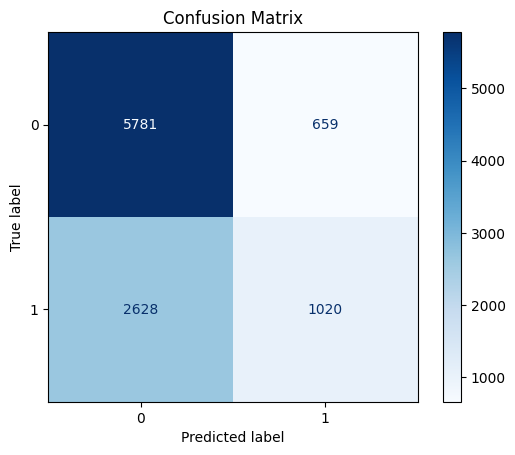

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

            outputs = model(X_test_batch, mode="classification")
            _, preds = torch.max(outputs, 1)

            correct += (preds == y_test_batch).sum().item()
            total += y_test_batch.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test_batch.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


evaluate_test(model, test_loader)


In [ ]:
# Fixed version of the hyperparameter search with correct tensor shapes

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba_ssm import Mamba
import json
import time
import pandas as pd
from pathlib import Path

class FixedSTMambaNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, config):
        super(FixedSTMambaNet, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Use config parameters
        conv_channels = config.get('conv_channels', [4, 4])
        dropout_rate = config.get('dropout_rate', 0.3)
        mamba_d_state = config.get('mamba_d_state', 8)

        self.kernel_sizes = [5, 9]
        self.conv_channels = conv_channels

        # Temporal convolutions
        self.temp_convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=out_ch,
                     kernel_size=(1, k), padding=(0, k // 2))
            for k, out_ch in zip(self.kernel_sizes, self.conv_channels)
        ])

        self.total_conv_channels = sum(self.conv_channels)
        self.batch_norm1 = nn.BatchNorm2d(self.total_conv_channels)
        self.spatial_conv = nn.Conv2d(in_channels=self.total_conv_channels,
                                    out_channels=self.total_conv_channels,
                                    kernel_size=(1, 1))
        self.batch_norm2 = nn.BatchNorm2d(self.total_conv_channels)
        self.activation = nn.ELU()

        # Pooling operations
        self.var_pool = lambda x: torch.var(x, dim=1, keepdim=True)
        self.avg_pool = lambda x: torch.mean(x, dim=1, keepdim=True)

        # Layer norms
        self.norm_t = nn.LayerNorm(55)
        self.norm_s = nn.LayerNorm(100)
        self.dropout = nn.Dropout(dropout_rate)

        # Feedforward networks
        self.feedforward_1 = nn.Sequential(
            nn.Linear(55, 32),
            nn.ReLU(),
            nn.Linear(32, 55)
        )
        self.feedforward_2 = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 100)
        )

        # Mamba layers with configurable d_state
        self.mamba_t = Mamba(d_model=55, d_state=mamba_d_state)
        self.mamba_s = Mamba(d_model=100, d_state=mamba_d_state)

        # Add conv encoders to handle different channel sizes
        self.conv_t = self._make_conv_encoder(110, 55)
        self.conv_s = self._make_conv_encoder(200, 100)

        # Identity pooling (keeping original behavior)
        self.pool_t = nn.Identity()
        self.pool_s = nn.Identity()

        # FIXED: Properly calculate FC input sizes
        # After processing, we get: temporal = (batch, 100, 55), spatial = (batch, 55, 100)
        self.fc_s = nn.Linear(55 * 100, 32)  # spatial path: 55 channels × 100 time points
        self.fc_t = nn.Linear(100 * 55, 32)  # temporal path: 100 time points × 55 channels

        self.fc_class = nn.Linear(64, num_classes)

    def _make_conv_encoder(self, in_channels, out_channels):
        """Create a simple conv encoder to match dimensions"""
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, mode="classification"):
        # Input: [batch, 55, 100]
        x = x.unsqueeze(1)  # [batch, 1, 55, 100]

        # Apply temporal convolutions
        x_convs = [conv(x) for conv in self.temp_convs]  # List of [batch, conv_ch, 55, 100]
        x = torch.cat(x_convs, dim=1)  # [batch, total_conv_channels, 55, 100]

        # Batch norm and spatial conv
        x = self.batch_norm1(x)
        x = self.spatial_conv(x)
        x = self.batch_norm2(x)
        x = self.activation(x)

        # Pooling over conv channels
        x_var = self.var_pool(x)  # [batch, 1, 55, 100]
        x_avg = self.avg_pool(x)  # [batch, 1, 55, 100]

        # Remove channel dimension and prepare for Mamba
        x_var = x_var.squeeze(1)  # [batch, 55, 100]
        x_avg = x_avg.squeeze(1)  # [batch, 55, 100]

        def shared_mamba_block(x, mamba, norm, feedforward):
            res1 = x
            x = norm(x)
            x = mamba(x)
            x = self.dropout(x) + res1
            res2 = x
            x = norm(x)
            x = feedforward(x) + res2
            return x

        # Temporal path: process along channel dimension (55)
        x_tvar = shared_mamba_block(x_var.permute(0, 2, 1), self.mamba_t,
                                  self.norm_t, self.feedforward_1)  # [batch, 100, 55]
        x_tavg = shared_mamba_block(x_avg.permute(0, 2, 1), self.mamba_t,
                                  self.norm_t, self.feedforward_1)  # [batch, 100, 55]
        x_t = torch.cat([x_tvar, x_tavg], dim=-1)  # [batch, 100, 110]

        # Spatial path: process along time dimension (100)
        x_svar = shared_mamba_block(x_var, self.mamba_s, self.norm_s, self.feedforward_2)  # [batch, 55, 100]
        x_savg = shared_mamba_block(x_avg, self.mamba_s, self.norm_s, self.feedforward_2)  # [batch, 55, 100]
        x_s = torch.cat([x_svar, x_savg], dim=-1)  # [batch, 55, 200]

        # Apply conv encoders to reduce dimensions
        x_tconv = self.conv_t(x_t.permute(0, 2, 1)).permute(0, 2, 1)  # [batch, 100, 55]
        x_sconv = self.conv_s(x_s.permute(0, 2, 1)).permute(0, 2, 1)  # [batch, 55, 100]

        # Apply pooling and flatten
        x_tconv = self.pool_t(x_tconv).reshape(x_tconv.shape[0], -1)  # [batch, 100*55]
        x_sconv = self.pool_s(x_sconv).reshape(x_sconv.shape[0], -1)  # [batch, 55*100]

        # Fully connected layers
        x_sfc = self.fc_s(x_sconv)  # [batch, 32]
        x_tfc = self.fc_t(x_tconv)  # [batch, 32]

        # Fusion and classification
        x_fused = torch.cat([x_sfc, x_tfc], dim=1)  # [batch, 64]

        if mode == "classification":
            return self.fc_class(x_fused)

class FixedHyperparameterSearchRunner:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test,
                 results_dir="hyperparameter_results"):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

        # Setup results directory
        self.results_dir = Path(results_dir)
        self.results_dir.mkdir(exist_ok=True)

        # Results tracking
        self.results = []
        self.best_config = None
        self.best_score = 0.0

        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def create_optimizer(self, model, config):
        """Create optimizer based on config"""
        lr = config.get('learning_rate', 1e-3)
        weight_decay = config.get('weight_decay', 1e-4)
        optimizer_type = config.get('optimizer_type', 'adam')

        if optimizer_type == 'adam':
            return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adamw':
            return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'sgd':
            return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
        else:
            return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def train_single_config(self, config, max_epochs=20):
        """Train model with a single configuration"""

        print(f"\n{'='*50}")
        print(f"Training with config: {config}")
        print(f"{'='*50}")

        # Create data loaders
        batch_size = config.get('batch_size', 32)

        train_dataset = TensorDataset(
            torch.tensor(self.X_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.long)
        )
        val_dataset = TensorDataset(
            torch.tensor(self.X_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.long)
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Create model with fixed architecture
        model = FixedSTMambaNet(
            input_size=100,
            hidden_size=config.get('hidden_size', 128),
            num_classes=2,
            config=config
        )
        model.to(self.device)

        # Create optimizer and scheduler
        optimizer = self.create_optimizer(model, config)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3, verbose=False
        )

        criterion = nn.CrossEntropyLoss()

        # Training loop
        best_val_acc = 0
        patience_counter = 0
        patience = 7

        for epoch in range(max_epochs):
            # Training
            model.train()
            train_correct = 0
            train_total = 0
            running_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs, mode="classification")
                loss = criterion(outputs, labels)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == labels).sum().item()
                train_total += labels.size(0)

            train_acc = train_correct / train_total

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs, mode="classification")
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

            val_acc = val_correct / val_total

            print(f"Epoch {epoch+1:2d}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {running_loss:.4f}")

            # Learning rate scheduling
            scheduler.step(val_acc)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), self.results_dir / "temp_best_model.pt")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Test evaluation with best model
        model.load_state_dict(torch.load(self.results_dir / "temp_best_model.pt"))
        model.eval()

        test_dataset = TensorDataset(
            torch.tensor(self.X_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.long)
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs, mode="classification")
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total

        results = {
            'val_accuracy': best_val_acc,
            'test_accuracy': test_acc,
            'final_train_accuracy': train_acc,
            'epochs_trained': epoch + 1
        }

        print(f"✅ Results: Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}")

        # Clean up
        del model
        torch.cuda.empty_cache()

        return results

    def run_search(self, search_configs, max_experiments=None, random_search=False):
        """Run hyperparameter search"""

        import random as rnd
        if random_search and max_experiments:
            search_configs = rnd.sample(search_configs, min(max_experiments, len(search_configs)))
        elif max_experiments:
            search_configs = search_configs[:max_experiments]

        print(f"Running hyperparameter search with {len(search_configs)} configurations...")

        start_time = time.time()

        for i, config in enumerate(search_configs):
            print(f"\n🔍 Experiment {i+1}/{len(search_configs)}")

            try:
                # Train with this configuration
                results = self.train_single_config(config)

                # Store results
                experiment_result = {
                    'experiment_id': i,
                    'config': config,
                    'results': results,
                    'timestamp': time.time()
                }

                self.results.append(experiment_result)

                # Update best configuration
                val_acc = results['val_accuracy']
                if val_acc > self.best_score:
                    self.best_score = val_acc
                    self.best_config = config.copy()
                    # Save best model permanently
                    import shutil
                    shutil.copy(
                        self.results_dir / "temp_best_model.pt",
                        self.results_dir / "best_model.pt"
                    )

                print(f"✅ Completed experiment {i+1} | Val Acc: {val_acc:.4f} | Best so far: {self.best_score:.4f}")

                # Save intermediate results
                self.save_results()

            except Exception as e:
                print(f"❌ Experiment {i+1} failed: {e}")
                import traceback
                traceback.print_exc()
                continue

        total_time = time.time() - start_time
        print(f"\n🏁 Search completed in {total_time/60:.1f} minutes")
        print(f"🏆 Best validation accuracy: {self.best_score:.4f}")
        print(f"🏆 Best configuration: {self.best_config}")

        return self.results

    def save_results(self):
        """Save results to files"""
        if not self.results:
            return

        # Save detailed results
        with open(self.results_dir / "search_results.json", 'w') as f:
            json.dump(self.results, f, indent=2)

        # Save best config
        with open(self.results_dir / "best_config.json", 'w') as f:
            json.dump({
                'best_score': self.best_score,
                'best_config': self.best_config
            }, f, indent=2)

        # Create summary DataFrame
        summary_data = []
        for result in self.results:
            row = result['config'].copy()
            row.update(result['results'])
            row['experiment_id'] = result['experiment_id']
            summary_data.append(row)

        df = pd.DataFrame(summary_data)
        df.to_csv(self.results_dir / "search_summary.csv", index=False)

        print(f"📁 Results saved to {self.results_dir}")

# Safer configuration set (smaller changes from original)
def create_safe_search_configs():
    """Create safer configurations that are closer to the original"""
    return [
        {
            'learning_rate': 1e-3,      # 10x increase (conservative)
            'mamba_d_state': 16,        # 2x increase
            'dropout_rate': 0.2,        # Slight decrease
            'batch_size': 64,           # 2x increase
            'hidden_size': 128,         # Same
            'conv_channels': [4, 4],    # Same as original
            'weight_decay': 1e-4,       # Same
        },
        {
            'learning_rate': 5e-4,      # 5x increase
            'mamba_d_state': 16,        # 2x increase
            'dropout_rate': 0.25,       # Slight decrease
            'batch_size': 32,           # Same
            'hidden_size': 128,         # Same
            'conv_channels': [6, 6],    # Moderate increase
            'weight_decay': 1e-4,       # Same
        },
        {
            'learning_rate': 2e-3,      # 20x increase (aggressive)
            'mamba_d_state': 8,         # Same
            'dropout_rate': 0.1,        # Big decrease
            'batch_size': 64,           # 2x increase
            'hidden_size': 256,         # 2x increase
            'conv_channels': [4, 4],    # Same
            'weight_decay': 1e-3,       # 10x increase
        }
    ]

print("✅ Fixed hyperparameter search runner ready!")
print("Run the cell below to start the search.")

✅ Fixed hyperparameter search runner ready!
Run the cell below to start the search.


In [ ]:
# Run this cell after copying the fixed code above

# Initialize the FIXED search runner
runner = FixedHyperparameterSearchRunner(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    results_dir="eeg_hyperparameter_results_fixed"
)

# Use safer configurations (smaller changes from original)
print("🚀 Starting FIXED hyperparameter search with safer configurations...")

safe_configs = create_safe_search_configs()

print("\nConfigurations to test:")
for i, config in enumerate(safe_configs):
    print(f"Config {i+1}: LR={config['learning_rate']}, d_state={config['mamba_d_state']}, "
          f"dropout={config['dropout_rate']}, batch={config['batch_size']}")

# Run the search
results = runner.run_search(safe_configs)

# Check results
print("\n📊 FINAL RESULTS:")
print(f"Best validation accuracy: {runner.best_score:.4f}")
print(f"Best configuration: {runner.best_config}")

# Display results if any succeeded
if runner.results:
    df = pd.read_csv("eeg_hyperparameter_results_fixed/search_summary.csv")
    print("\n📈 All results:")
    print(df[['val_accuracy', 'test_accuracy', 'learning_rate', 'mamba_d_state', 'dropout_rate', 'batch_size']])
else:
    print("❌ No experiments succeeded. Check the error messages above.")

Using device: cuda
🚀 Starting FIXED hyperparameter search with safer configurations...

Configurations to test:
Config 1: LR=0.001, d_state=16, dropout=0.2, batch=64
Config 2: LR=0.0005, d_state=16, dropout=0.25, batch=32
Config 3: LR=0.002, d_state=8, dropout=0.1, batch=64
Running hyperparameter search with 3 configurations...

🔍 Experiment 1/3

Training with config: {'learning_rate': 0.001, 'mamba_d_state': 16, 'dropout_rate': 0.2, 'batch_size': 64, 'hidden_size': 128, 'conv_channels': [4, 4], 'weight_decay': 0.0001}
Epoch  1: Train Acc: 0.5448 | Val Acc: 0.5903 | Loss: 326.6547
Epoch  2: Train Acc: 0.5927 | Val Acc: 0.6040 | Loss: 306.8947
Epoch  3: Train Acc: 0.6158 | Val Acc: 0.6199 | Loss: 299.2024
Epoch  4: Train Acc: 0.6266 | Val Acc: 0.6172 | Loss: 294.2930
Epoch  5: Train Acc: 0.6385 | Val Acc: 0.6133 | Loss: 289.4210
Epoch  6: Train Acc: 0.6527 | Val Acc: 0.6106 | Loss: 283.2629
Epoch  7: Train Acc: 0.6697 | Val Acc: 0.5873 | Loss: 275.7833
Epoch  8: Train Acc: 0.7120 | Val 

KeyboardInterrupt: 

In [ ]:
import itertools
import random

def create_grid_search_configs():
    """Create full grid search configurations"""
    configs = {
        'learning_rate': [5e-4, 1e-3, 2e-3],
        'mamba_d_state': [8, 16, 32],
        'dropout_rate': [0.1, 0.2, 0.3],
        'batch_size': [32, 64],
        'hidden_size': [128, 256],
        'conv_channels': [[4, 4], [8, 8]],
        'weight_decay': [1e-4, 1e-3],
    }

    keys = list(configs.keys())
    values = list(configs.values())

    search_space = []
    for combination in itertools.product(*values):
        config_dict = dict(zip(keys, combination))
        search_space.append(config_dict)

    return search_space

def create_reduced_grid_search():
    """Create a smaller, more focused grid search"""
    configs = {
        'learning_rate': [1e-3, 2e-3],           # Focus on higher LR
        'mamba_d_state': [16, 32],               # Skip smallest
        'dropout_rate': [0.1, 0.2],              # Skip highest
        'batch_size': [64],                      # Fix at 64
        'hidden_size': [128, 256],               # Keep both
        'conv_channels': [[4, 4], [8, 8]],       # Keep both
        'weight_decay': [1e-4],                  # Fix weight decay
    }

    keys = list(configs.keys())
    values = list(configs.values())

    search_space = []
    for combination in itertools.product(*values):
        config_dict = dict(zip(keys, combination))
        search_space.append(config_dict)

    return search_space

# OPTION 1: Full grid search (432 configs - takes 15-30 hours)
print("🔍 OPTION 1: Full Grid Search")
full_grid_configs = create_grid_search_configs()
print(f"Total configurations: {len(full_grid_configs)}")
print(f"Estimated time: {len(full_grid_configs) * 3} minutes = {len(full_grid_configs) * 3 / 60:.1f} hours")

# OPTION 2: Reduced grid search (16 configs - takes 1-2 hours)
print("\n🎯 OPTION 2: Reduced Grid Search (Recommended)")
reduced_grid_configs = create_reduced_grid_search()
print(f"Total configurations: {len(reduced_grid_configs)}")
print(f"Estimated time: {len(reduced_grid_configs) * 3} minutes = {len(reduced_grid_configs) * 3 / 60:.1f} hours")

# OPTION 3: Random sample from full grid (20 configs - takes 1 hour)
print("\n🎲 OPTION 3: Random Sample from Full Grid")
random_sample_size = 20
random_configs = random.sample(full_grid_configs, random_sample_size)
print(f"Total configurations: {len(random_configs)}")
print(f"Estimated time: {len(random_configs) * 3} minutes = {len(random_configs) * 3 / 60:.1f} hours")

# Show sample configurations
print("\n📋 Sample configurations from reduced grid:")
for i, config in enumerate(reduced_grid_configs[:3]):
    print(f"Config {i+1}: {config}")

🔍 OPTION 1: Full Grid Search
Total configurations: 432
Estimated time: 1296 minutes = 21.6 hours

🎯 OPTION 2: Reduced Grid Search (Recommended)
Total configurations: 32
Estimated time: 96 minutes = 1.6 hours

🎲 OPTION 3: Random Sample from Full Grid
Total configurations: 20
Estimated time: 60 minutes = 1.0 hours

📋 Sample configurations from reduced grid:
Config 1: {'learning_rate': 0.001, 'mamba_d_state': 16, 'dropout_rate': 0.1, 'batch_size': 64, 'hidden_size': 128, 'conv_channels': [4, 4], 'weight_decay': 0.0001}
Config 2: {'learning_rate': 0.001, 'mamba_d_state': 16, 'dropout_rate': 0.1, 'batch_size': 64, 'hidden_size': 128, 'conv_channels': [8, 8], 'weight_decay': 0.0001}
Config 3: {'learning_rate': 0.001, 'mamba_d_state': 16, 'dropout_rate': 0.1, 'batch_size': 64, 'hidden_size': 256, 'conv_channels': [4, 4], 'weight_decay': 0.0001}


In [ ]:
# CHOOSE ONE OF THESE OPTIONS TO RUN:

# Make sure you have the FixedHyperparameterSearchRunner from the previous cell

# ============================================================================
# OPTION 1: QUICK REDUCED GRID SEARCH (Recommended to start)
# Time: 1-2 hours, 16 experiments
# ============================================================================

print("🎯 Running REDUCED GRID SEARCH (16 configs)")
configs = create_reduced_grid_search()

runner = FixedHyperparameterSearchRunner(
    X_train, y_train, X_val, y_val, X_test, y_test,
    results_dir="grid_search_reduced"
)

results = runner.run_search(configs)
print(f"\n🏆 Best from reduced grid: {runner.best_score:.4f}")

In [ ]:

# ============================================================================
# OPTION 2: RANDOM SAMPLE FROM FULL GRID
# Time: 1 hour, 20 experiments
# ============================================================================

print("🎲 Running RANDOM SAMPLE from full grid (20 configs)")
full_configs = create_grid_search_configs()

runner = FixedHyperparameterSearchRunner(
    X_train, y_train, X_val, y_val, X_test, y_test,
    results_dir="grid_search_random"
)

results = runner.run_search(full_configs, max_experiments=20, random_search=True)
print(f"\n🏆 Best from random sample: {runner.best_score:.4f}")


In [ ]:
# ============================================================================
# OPTION 3: FULL GRID SEARCH (Run overnight!)
# Time: 15-30 hours, 432 experiments
# ============================================================================

print("🔍 Running FULL GRID SEARCH (432 configs) - This will take 15-30 hours!")
full_configs = create_grid_search_configs()

runner = FixedHyperparameterSearchRunner(
    X_train, y_train, X_val, y_val, X_test, y_test,
    results_dir="grid_search_full"
)

results = runner.run_search(full_configs)
print(f"\n🏆 Best from full grid: {runner.best_score:.4f}")


In [ ]:
# ============================================================================
# OPTION 4: SMART PROGRESSIVE SEARCH
# Start small, then expand based on results
# ============================================================================

print("🧠 Running SMART PROGRESSIVE SEARCH")

# Step 1: Test a few promising configs
safe_configs = create_safe_search_configs()
runner.run_search(safe_configs)
best_safe = runner.best_score

# Step 2: If improvement, run reduced grid
if best_safe > 0.63:
    print(f"✅ Safe configs achieved {best_safe:.3f}, running reduced grid...")
    reduced_configs = create_reduced_grid_search()
    runner.run_search(reduced_configs)
    best_reduced = runner.best_score

    # Step 3: If still improving, run random sample
    if best_reduced > 0.65:
        print(f"✅ Reduced grid achieved {best_reduced:.3f}, running random sample...")
        full_configs = create_grid_search_configs()
        runner.run_search(full_configs, max_experiments=50, random_search=True)

print("\n📊 FINAL RESULTS:")
print(f"Best validation accuracy: {runner.best_score:.4f}")
print(f"Best test accuracy: {[r['results']['test_accuracy'] for r in runner.results if r['results']['val_accuracy'] == runner.best_score][0]:.4f}")
print(f"Best configuration: {runner.best_config}")

# Analyze results
if runner.results:
    import pandas as pd
    df = pd.read_csv(f"{runner.results_dir}/search_summary.csv")

    print(f"\n📈 TOP 5 CONFIGURATIONS:")
    top_5 = df.nlargest(5, 'val_accuracy')
    print(top_5[['val_accuracy', 'test_accuracy', 'learning_rate', 'mamba_d_state', 'dropout_rate', 'batch_size']])

    print(f"\n📊 ANALYSIS:")
    print(f"Learning rate - Best performers: {top_5['learning_rate'].value_counts().head(3).to_dict()}")
    print(f"Mamba d_state - Best performers: {top_5['mamba_d_state'].value_counts().head(3).to_dict()}")
    print(f"Dropout rate - Best performers: {top_5['dropout_rate'].value_counts().head(3).to_dict()}")

    # Find improvement over baseline
    baseline_acc = 0.6443  # Your original accuracy
    best_acc = runner.best_score
    improvement = (best_acc - baseline_acc) / baseline_acc * 100
    print(f"\n🚀 IMPROVEMENT: {improvement:+.1f}% over baseline ({baseline_acc:.4f} → {best_acc:.4f})")

🧠 Running SMART PROGRESSIVE SEARCH
Running hyperparameter search with 3 configurations...

🔍 Experiment 1/3

Training with config: {'learning_rate': 0.001, 'mamba_d_state': 16, 'dropout_rate': 0.2, 'batch_size': 64, 'hidden_size': 128, 'conv_channels': [4, 4], 'weight_decay': 0.0001}
Epoch  1: Train Acc: 0.5422 | Val Acc: 0.5870 | Loss: 327.1534
Epoch  2: Train Acc: 0.5993 | Val Acc: 0.6122 | Loss: 304.2261
Epoch  3: Train Acc: 0.6209 | Val Acc: 0.6243 | Loss: 296.4023
Epoch  4: Train Acc: 0.6359 | Val Acc: 0.6243 | Loss: 290.0640
Epoch  5: Train Acc: 0.6507 | Val Acc: 0.5969 | Loss: 284.0278
Epoch  6: Train Acc: 0.6680 | Val Acc: 0.6235 | Loss: 277.0415
Epoch  7: Train Acc: 0.6884 | Val Acc: 0.6287 | Loss: 267.9443
Epoch  8: Train Acc: 0.7089 | Val Acc: 0.6062 | Loss: 255.5249
Epoch  9: Train Acc: 0.7406 | Val Acc: 0.6070 | Loss: 239.0148
Epoch 10: Train Acc: 0.7624 | Val Acc: 0.6010 | Loss: 221.0621
Epoch 11: Train Acc: 0.8011 | Val Acc: 0.5908 | Loss: 197.3134
Epoch 12: Train Acc: 0

KeyboardInterrupt: 